In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import string

In [15]:
device="cuda:1"
model_name = "gemma-2-2b"
# local_model_path
use_sae= True

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    #attn_implementation="flash_attention_2",
    ).to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
dataset_path = "../SimpleStories_data/data_250_samples.json"

dataset_list = json.loads(open(dataset_path).read())

total_tokens = 0
check_tokens = []
for sent in dataset_list:
    tokens = tokenizer.encode(dataset_list[sent], add_special_tokens=False)  
    total_tokens += len(tokens)
    check_tokens.append(tokens)

print(f"token num: {total_tokens}")

if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token  
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'}) 
        model.resize_token_embeddings(len(tokenizer))  


token num: 70206


In [18]:
def batch_iter(dataset, batch_size=64):
    batch = []
    for idx in range(len(dataset)):
        batch.append((idx, dataset[str(idx)]))
        if len(batch) >= batch_size:
            yield batch
            batch=[]
    if batch:
        yield batch

def preproc(batch):
    sent_ids = []
    text_data = []
    for idx, text in batch:
        sent_ids.append(int(idx))
        text_data.append(text)
    input_data = tokenizer(
        text_data,
        padding="longest",
        max_length=256,
        truncation=True,
        return_tensors="pt",
        )
    input_data["sent_ids"] = sent_ids
    return input_data

def is_valid_token(token_str):
    token_lower = token_str.lower()
    tokens = {"<bos>", "<eos>", "<pad>", "<unk>"," "}
    if token_lower in tokens:
        return False

    if token_str.isdigit():
        return False
    if all(c in string.punctuation for c in token_str):
        return False
    
    return True

batch_size=32

### Load SAEs of layers from gemma-scope 

In [26]:
if use_sae:
    from sae_lens import SAE
    sae_per_layer = {}
    for i in tqdm(range(25,26)):
        result = SAE.from_pretrained(
            release="gemma-scope-2b-pt-res-canonical",  # <- Release name
            sae_id=f"layer_{i}/width_16k/canonical",  # <- SAE id (not always a hook point!)
            device='cpu',
        )
        
        sae_obj = result    
        sae_per_layer[f"layer_{i}"] = sae_obj
        print(f"Layer {i}: {type(sae_obj)}")
        sae_per_layer[f"layer_{i}"].fold_W_dec_norm()


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

Layer 25: <class 'sae_lens.saes.jumprelu_sae.JumpReLUSAE'>


In [22]:
import torch
import torch.nn.functional as F
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle as pkl

if use_sae:
    print("SAE Latents")
else:
    print("LLM Hidden States")

# 9b layers:42
# 2b layers 26

layers=[i for i in range(0,2)]
layers=[25]
vectors_in_diff_layers=[]

for layer in layers:
    all_token_vectors = []  
    all_token_ids = []
    token_nums={}
    global_token_count = 0 
    
    if use_sae:
        print(f"recording SAE features of Layer {layer} ...")
        sae = sae_per_layer[f"layer_{layer}"]
        sae.eval()  
    else:
        print(f"recording hidden states of Layer {layer} ...")
    
    current_batch_iterator = batch_iter(dataset_list, batch_size)
    for batch in tqdm(current_batch_iterator, total=len(dataset_list)//batch_size+1):
        input_data = preproc(batch)
        input_ids = input_data["input_ids"].to(device)

        sent_ids = input_data["sent_ids"] 
        mask = input_data["attention_mask"].to(device)
        
        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=mask, output_hidden_states=True)
        
        hidden_states = output["hidden_states"][layer]  # [batch_size, seq_len, hidden_dim]
        batch_size_actual, seq_len, hidden_dim = hidden_states.shape
        
        # every sent 
        for i in range(batch_size_actual):
            current_sent_id = sent_ids[i]
            # every token
            for j in range(seq_len):
                token_id = input_ids[i, j].item()
                if (not is_valid_token(tokenizer.decode(token_id))):
                    continue
                if token_id in token_nums:
                    token_nums[token_id]+=1
                else:
                    token_nums[token_id]=1
                
                if use_sae:
                    token_hidden = hidden_states[i, j].to(sae.cfg.device).unsqueeze(0)  # [1, hidden_dim]
                    sae_features = sae.encode(token_hidden)  # [1, d_sae]
                    token_vec = sae_features.squeeze(0).cpu()  
                else:
                    token_vec = hidden_states[i, j].cpu()  # [hidden_dim]
                
                all_token_vectors.append(token_vec)
 
                token_str=tokenizer.decode(token_id)
                token_sample_id = f"{token_str}-{token_nums[token_id]}"
                all_token_ids.append(token_sample_id)
                
                global_token_count += 1
    
    if use_sae:
        print(f"  Layer {layer}: SAE latents of {len(all_token_vectors)}  tokens")
    else:
        print(f"  Layer {layer}: hidden states of {len(all_token_vectors)} tokens")
    
    if len(all_token_vectors) > 0:
        print(f"     feature dimension: {all_token_vectors[0].shape}")
    
    vectors_in_diff_layers.append(all_token_vectors)



SAE Latents
recording SAE features of Layer 25 ...


100%|██████████| 8/8 [00:50<00:00,  6.26s/it]

  Layer 25: SAE latents of 44109  tokens
     feature dimension: torch.Size([16384])


In [23]:
import torch
import torch.nn.functional as F
import pandas as pd

all_avg_cos=[]
for idx,layer in enumerate(layers):
    print(f"layer {layer} avg_cos:")
    all_token_vectors = torch.stack(vectors_in_diff_layers[idx])
    all_token_vectors = F.normalize(all_token_vectors, p=2, dim=1)
    
    # cos_sim[i, j] 
    cos_sim_matrix = all_token_vectors @ all_token_vectors.T   
    n = cos_sim_matrix.shape[0]
    cos_sim_matrix_no_diag = cos_sim_matrix - 2.0 * torch.eye(n, device=cos_sim_matrix.device)
    
    # highest cos similarity of each feature pair
    max_similarities = cos_sim_matrix_no_diag.detach().max(dim=1).values.cpu().numpy() 
    avg_cos = max_similarities.mean()
    
    all_avg_cos.append(avg_cos.item())
    print(f"\t{avg_cos}")

layer 25 avg_cos:
	0.8139471411705017


In [11]:
df = pd.DataFrame(all_avg_cos,columns=['cos_sim'],index=layers)
filename = f"{model_name.split('/')[-1]}_{layers[0]}-{layers[-1]}_{'use_sae' if use_sae else 'hidden_states'}.csv"
print(filename)
if use_sae:
    df.to_csv(f"../results/sae_latent/{filename}")
else:
    df.to_csv(f"../results/hidden_stats/{filename}")

gemma-2-2b_0-1_hidden_states.csv


## Draw 

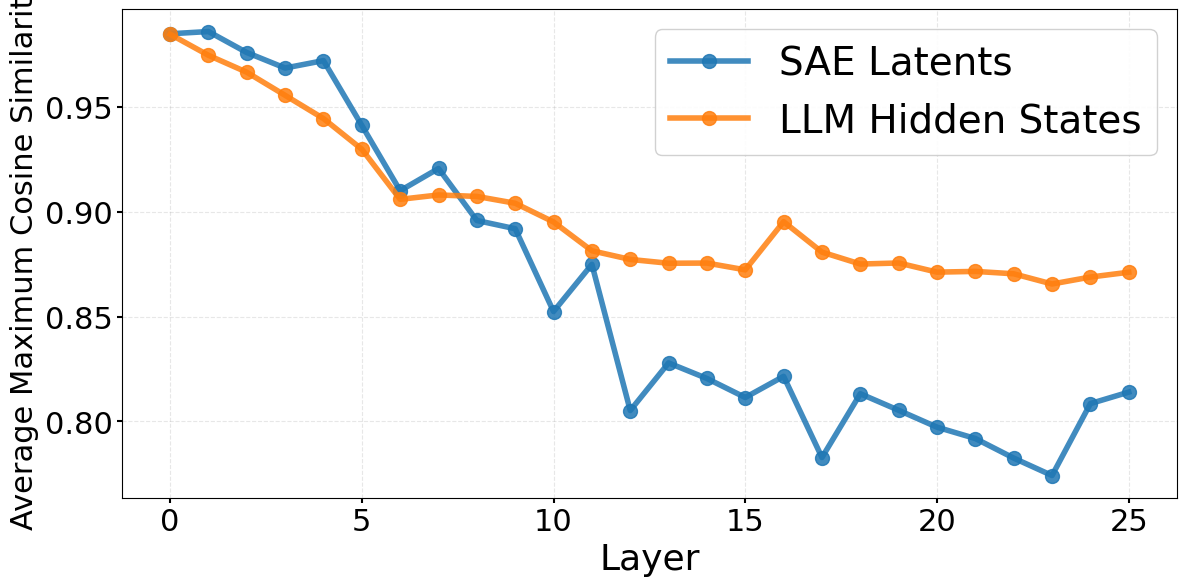

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import seaborn as sns 
 
directory_path = "../results/Avg_max_cos_of_gemma_scope/final"

DATA_COLUMN_NAME = 'cos_sim' 

color_scheme = {
    '2b': {
        'hidden_stat': '#A8D5E2',  
        'sae_latent': '#1E5F8C'    
    },
    '9b': {
        'hidden_stat': '#FFD699',  
        'sae_latent': '#D97706'    
    }
}

plot_data = []
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        
        line_label = os.path.splitext(filename)[0]
        if 'sae' in line_label:
            line_label = 'SAE Latents'
        else:
            line_label = 'LLM Hidden States'
        df = pd.read_csv(file_path)
        
        if DATA_COLUMN_NAME in df.columns:
            y_values = df[DATA_COLUMN_NAME].values
        elif len(df.columns) > 0:
            y_values = df.iloc[:, 0].values
        else:
            print(f"SKIP:  {filename} has no useful data")
            continue
        
        model_type = None
        data_type = None
        
        if '2b' in filename.lower():
            model_type = '2b'
        elif '9b' in filename.lower():
            model_type = '9b'
        
        if 'hidden_stat' in filename.lower():
            data_type = 'hidden_stat'
        elif 'sae_latent' in filename.lower():
            data_type = 'sae_latent'
        
        color = None
        if model_type and data_type:
            color = color_scheme.get(model_type, {}).get(data_type)
        
        plot_data.append({
            'label': line_label,
            'y_values': y_values,
            'model_type': model_type,
            'data_type': data_type,
            'color': color
        })

# soted：2b->9b; hidden_stat->sae_latent
def sort_key(item):
    model_order = {'2b': 0, '9b': 1, None: 2}
    data_order = {'hidden_stat': 0, 'sae_latent': 1, None: 2}
    return (model_order.get(item['model_type'], 2), data_order.get(item['data_type'], 2))

plot_data.sort(key=sort_key)

plt.figure(figsize=(12, 6))

max_len = max(len(data['y_values']) for data in plot_data)

for data in plot_data:
    y = data['y_values']
    label = data['label']
    color = data['color']
    
    x = list(range(len(y)))
    
    linestyle = '-' 
    linewidth = 4
    marker_size = 10
    
    if color:
        plt.plot(x, y, marker='o', linestyle=linestyle, linewidth=linewidth,
                markersize=marker_size, color=color, label=label, alpha=0.85)
    else:
        plt.plot(x, y, marker='o', linestyle=linestyle, linewidth=linewidth,
                markersize=marker_size, label=label, alpha=0.85)

plt.xlabel("Layer", fontsize=26)
plt.ylabel(f"Average Maximum Cosine Similarity", fontsize=22)

if max_len > 0 and max_len < 20:
    plt.xticks(np.arange(0, max_len))

plt.grid(True, linestyle='--', alpha=0.3)

plt.legend(loc='upper right', fontsize=28, framealpha=0.9)
ax = plt.gca()

# for spine in ax.spines.values():
#     spine.set_visible(True)
#     spine.set_edgecolor('black')  
#     spine.set_linewidth(1.5)     

ax.tick_params(which='both', 
               width=1.5, colors='black', labelsize=22)

plt.tight_layout(pad=1.2) 

plt.savefig(f"../results/cos_of_gemma_scope/final/cos_diff_across_layers.pdf", 
            bbox_inches='tight', pad_inches=0.05)
plt.show()